# PoseNet for Self-Localization on Apolloscape Dataset

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


## Load Apolloscape Dataset

In [8]:
APOLLO_PATH = "./data/apolloscape"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor(),
    normalize
])


train_record = None # 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = None # 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)

test_record = 'Record013'
test_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=test_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)



print(train_dataset)
print(val_dataset)
print(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=16) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=16) # batch_size = 75
test_dataloader = DataLoader(test_dataset, batch_size=16) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: None
    Train: True
    Normalize Poses: True
    Length: 1121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: None
    Train: False
    Normalize Poses: True
    Length: 378 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record013
    Train: False
    Normalize Poses: True
    Length: 120 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 

## Draw Train and Val datasets

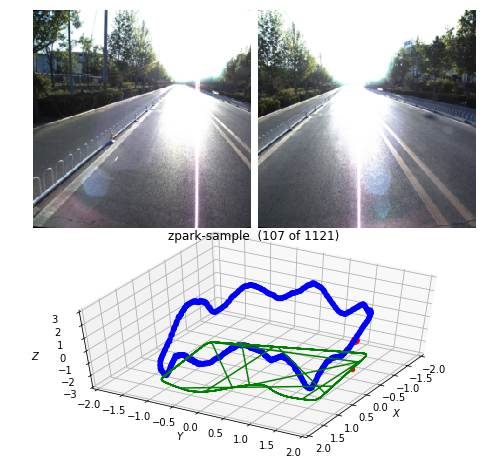

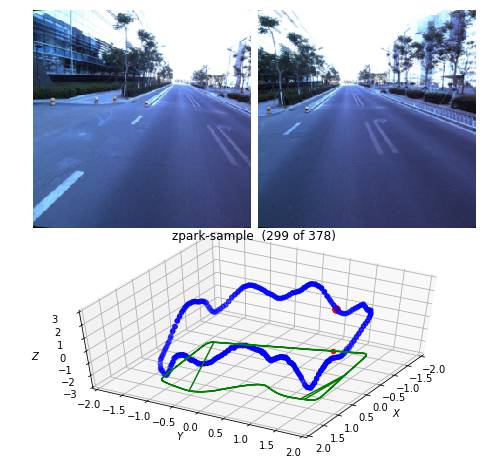

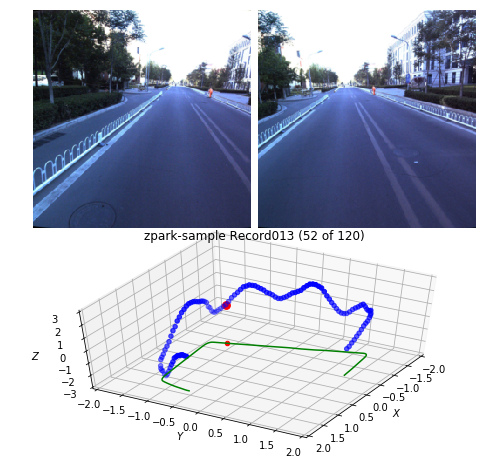

In [3]:
# Draw datasets
draw_record(train_dataset)
plt.show()

draw_record(val_dataset)
plt.show()

draw_record(test_dataset)
plt.show()

## Device set up

In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cpu


## Train and Validate Functions

In [5]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    # switch model to training
    model.train()
    
    losses = AverageMeter()
    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
    if print_sum:
        print('Epoch: [{}/{}]\tTraining Loss: {:.3f}'.format(epoch, max_epoch - 1, losses.avg))
        
    return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}'.format(epoch, losses.avg))
        
    return losses.avg


## Create Model, Criterion and Optimizer

In [6]:
# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Create model
model = PoseNet(feature_extractor)
model = model.to(device)

# Criterion
criterion = PoseNetCriterion()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

start_epoch = 0


## Restore from Chekpoint

In [7]:
# Restore from checkpoint
checkpoint_file = '_checkpoints/20180804_130647_apollo_zpark_r001_v2_e036.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


Loading from checkpoint: _checkpoints/20180804_130647_apollo_zpark_r001_v2_e036.pth.tar


## Run Training

In [9]:
if 'start_epoch' not in locals():
    start_epoch = 0
    
# train_dataloader = DataLoader(train_dataset, batch_size=8) # batch_size = 75
# optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.0005)

n_epochs = start_epoch + 1
print('Training ...')
val_freq = 5
for e in range(start_epoch, n_epochs):

    end = time.time()
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=1)
#     print('Train epoch time: {:.3f}'.format(time.time() - end))
    
#     print('Validation ...')
    if e & val_freq == 0:
        end = time.time()
        validate(val_dataloader, model, criterion, e, log_freq=1)
#     print('Validation epoch time: {:.3f}'.format(time.time() - end))

#     print('Test dataset ...')
#     validate(test_dataloader, model, criterion, e, log_freq=0)

start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))


Training ...
Epoch: [36/36]	Batch: [0/70]	Time: 18.453	Data Time: 0.512	Loss: 348.245	Avg Loss: 348.245	
Epoch: [36/36]	Batch: [1/70]	Time: 16.581	Data Time: 0.536	Loss: 385.948	Avg Loss: 367.097	
Epoch: [36/36]	Batch: [2/70]	Time: 14.518	Data Time: 0.687	Loss: 333.387	Avg Loss: 355.860	
Epoch: [36/36]	Batch: [3/70]	Time: 12.618	Data Time: 0.511	Loss: 301.516	Avg Loss: 342.274	
Epoch: [36/36]	Batch: [4/70]	Time: 12.455	Data Time: 0.473	Loss: 302.842	Avg Loss: 334.388	
Epoch: [36/36]	Batch: [5/70]	Time: 12.295	Data Time: 0.497	Loss: 300.967	Avg Loss: 328.818	
Epoch: [36/36]	Batch: [6/70]	Time: 12.313	Data Time: 0.489	Loss: 364.267	Avg Loss: 333.882	
Epoch: [36/36]	Batch: [7/70]	Time: 16.048	Data Time: 4.118	Loss: 364.928	Avg Loss: 337.763	
Epoch: [36/36]	Batch: [8/70]	Time: 21.089	Data Time: 8.988	Loss: 296.847	Avg Loss: 333.216	
Epoch: [36/36]	Batch: [9/70]	Time: 21.108	Data Time: 8.541	Loss: 341.179	Avg Loss: 334.013	
Epoch: [36/36]	Batch: [10/70]	Time: 26.590	Data Time: 9.024	Loss: 3

## Test Model Error on Validation and Train Datasets


=== Test Training Dataloader ======
loss = 318.5571594238281
loss = 378.9682312011719
loss = 314.27911376953125
loss = 289.74407958984375
loss = 288.22271728515625
loss = 289.65765380859375
loss = 366.18743896484375
loss = 351.1796875
loss = 288.690185546875
loss = 331.3499755859375
loss = 378.0394592285156
loss = 338.3327331542969
loss = 318.6270751953125
loss = 364.85247802734375
loss = 327.51983642578125
loss = 352.6090087890625
loss = 317.1393127441406
loss = 334.5924072265625
loss = 342.1575927734375
loss = 312.47607421875
loss = 378.5306701660156
loss = 312.178955078125
loss = 308.2437744140625
loss = 311.8078308105469
loss = 373.4030456542969
loss = 336.2892761230469
loss = 288.5536193847656
loss = 289.5205078125
loss = 289.58404541015625
loss = 365.44329833984375
loss = 377.7403564453125
loss = 339.14056396484375
loss = 315.89227294921875
loss = 366.564208984375
loss = 311.5455627441406
loss = 340.2663879394531
loss = 368.85626220703125
loss = 318.1569519042969
loss = 344.9734

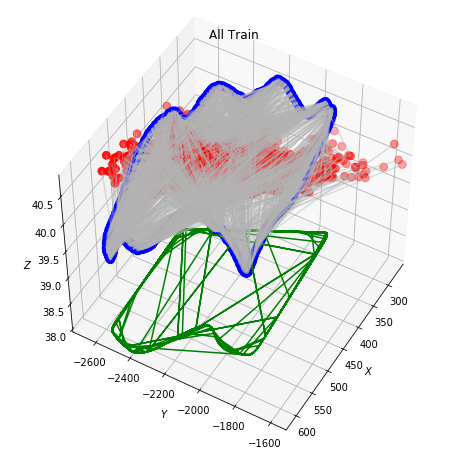

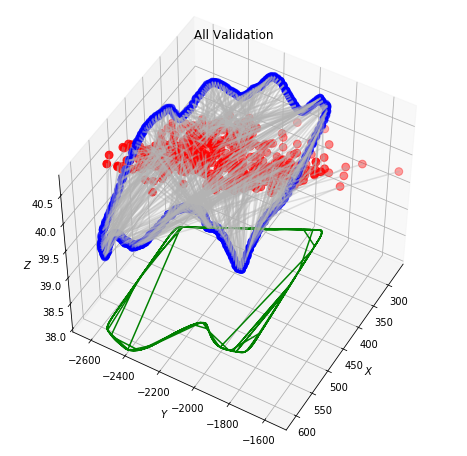

In [10]:
def quaternion_angular_error(q1, q2):
    """
    angular error between two quaternions
    :param q1: (4, )
    :param q2: (4, )
    :return:
    """
    d = abs(np.dot(q1, q2))
    abs_q1 = np.linalg.norm(q1)
    abs_q2 = np.linalg.norm(q2)
    d = d / (abs_q1 * abs_q2)
    d = min(1.0, max(-1.0, d))
    theta = 2 * np.arccos(d) * 180 / np.pi
    return theta

def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=True, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()

    
def model_results_pred_gt(model, dataloader, poses_mean, poses_std):
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_poses) in enumerate(dataloader):
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]

        out = model(batch_images)
        
        loss = criterion(out, batch_poses)
        print('loss = {}'.format(loss))

        # move data to cpu & numpy
        batch_poses = [x.detach().cpu().numpy() for x in batch_poses]
        out = [x.detach().cpu().numpy() for x in out]

        gt_poses = np.vstack((gt_poses, *batch_poses))
        pred_poses = np.vstack((pred_poses, *out))
        
    # un-normalize translation
    gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
    pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    return pred_poses, gt_poses



poses_mean = val_dataset.poses_mean
poses_std = val_dataset.poses_std




print('\n=== Test Training Dataloader ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_dataloader, poses_mean, poses_std)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

pred_poses_train = pred_poses
gt_poses_train = gt_poses


print('\n=== Test Validation Dataloader ======')
pred_poses, gt_poses = model_results_pred_gt(model, val_dataloader, poses_mean, poses_std)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

pred_poses_val = pred_poses
gt_poses_val = gt_poses


draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('All Train')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('All Validation')
plt.show()




## Save Model Checkpoint

In [14]:
# Save checkpoint
save_checkpoint(model, optimizer, 'apollo_zpark_r001_v2', n_epochs)
    

'_checkpoints/20180804_135016_apollo_zpark_r001_v2_e037.pth.tar'